# Compute MHWs from Sea surface temperature



The goal of the code is to compute Marine Heatwaves (MHWs) from daily temperature time-series data obtained from the ESA SST product, extracted close to Sydney. It processes the data by selecting the input files, gridding the data onto a regular grid (still daily, but with specific start and date), and then applying the MHW detection algorithm. The detected MHW events are analyzed and relevant information is saved in a shelf file for further analysis. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import datetime
import netCDF4 
from datetime import date
from datetime import timedelta
import glob
import xarray as xr
import pandas as pd



# Load Sea surface temperature data

Load data (Netcdf time-series extracted at close-by pixel)

In [2]:
Name_platform = 'SST_ESA'
ClimatologyPeriod=[1992,2019]
MHWPeriod = [1992,2019]
mhwname = 'MHWS'
depth = 0
plot_folder  = 'FIGURES/' # including 2019 need to change Nans in # Create dataframe and recalculate summer and winter with it


In [3]:
# Create a regular daily time vector from 1 Jan 1992 to 31 Dec 2019
from datetime import timedelta
times_dates = np.arange(datetime.datetime(ClimatologyPeriod[0],1,1), datetime.datetime(ClimatologyPeriod[1]+1,1,1), timedelta(days=1)).astype(datetime.datetime)
t = np.array([times_dates[i].toordinal() for i in range(len(times_dates)) ])  # final daily time vector 

times_dates

array([datetime.datetime(1992, 1, 1, 0, 0),
       datetime.datetime(1992, 1, 2, 0, 0),
       datetime.datetime(1992, 1, 3, 0, 0), ...,
       datetime.datetime(2019, 12, 29, 0, 0),
       datetime.datetime(2019, 12, 30, 0, 0),
       datetime.datetime(2019, 12, 31, 0, 0)], dtype=object)

In [4]:
# Get data with xarray
SST_xr = xr.open_dataset('DATA_raw_other/GLO-SST-L4-REP-OBS-SST_1600741056485_1992_C3S_2019_SYD_34_1514.nc')

lat = SST_xr.lat.values
lon = SST_xr.lon.values
times = SST_xr.time.values
times_dates0 = pd.to_datetime(SST_xr.time.values)

t0 = np.array([times_dates0[i].toordinal() for i in range(len(times_dates0)) ])
sst_K = SST_xr.analysed_sst[:,0,0]   # Kelvin
sst0 = sst_K.values - 273.15  # Celcius
sst_K


<xarray.DataArray 'analysed_sst' (time: 10592)>
array([295.75   , 295.75998, 295.88998, ..., 292.72   , 292.9    , 293.09   ],
      dtype=float32)
Coordinates:
    lat      float32 -34.03
    lon      float32 151.1
  * time     (time) datetime64[ns] 1991-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_water_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         ATSR<1,2>-ESACCI-L3U-v2.0, AATSR-ESACCI-L3U-v2.0, AVHRR<0...
    _ChunkSizes:    [   1 1200 2400]
    cell_methods:   record: mean time: mean

In [5]:
# Match the SST data with a regular grid
T = len(t)  
sst = np.zeros((T)) + np.nan
t0_day = np.int0(t0)
for i in range(T):
    # Match day-of-year values and average if the resolution is higher than daily
    t0_ind = np.where(t0_day == t[i])[0]
    if np.isfinite(t0_ind):
        sst[i] = np.nanmean(sst0[t0_ind.astype(int)])


C:\Users\Amandine\AppData\Local\Temp\ipykernel_8764\4270942369.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  t0_day = np.int0(t0)


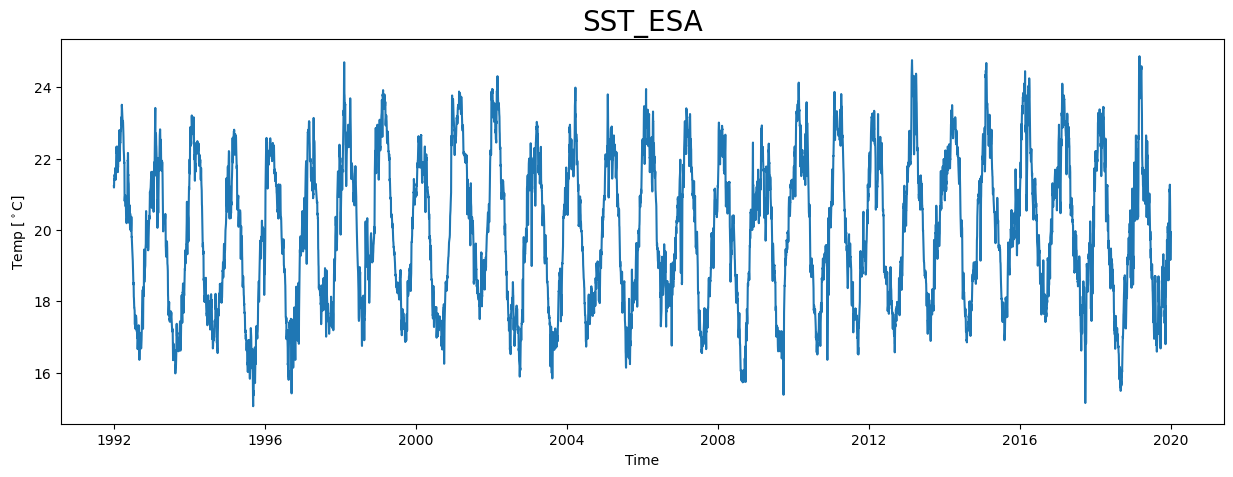

Percentage of NaN= 0.0


In [6]:
### Plot
plt.figure(1,figsize=(15,5))
plt.plot(times_dates,sst)
plt.xlabel('Time')
plt.ylabel('Temp [$^\circ$C]')
plt.title(Name_platform, size=20)
plt.savefig(plot_folder + 'Plot_sst.png')
plt.show()

# Percentage nans....
Nb_nans = sum(np.isnan(sst))/len(sst)
print('Percentage of NaN= ' + str(Nb_nans))


# Run MHW toolbox (Hobday et al., Oliver)

In [7]:
## Run MHW algorithm from Hobday et al, 2016 and https://github.com/ecjoliver/marineHeatWaves  
import marineHeatWaves_AS_v2 as mhw_v2 # CAREFUL! marineHeatWaves pads sst with climatology
mhws, clim = mhw_v2.detect(t, sst, climatologyPeriod=ClimatologyPeriod,MHWPeriod=MHWPeriod,smoothPercentileWidth=31)

# Make sure there is no interpolation or replacement with climatology...
sst[clim['missing']]=np.nan # reverse the padding of sst 


3.995914679709989e-05
7.3611308471094265e-09


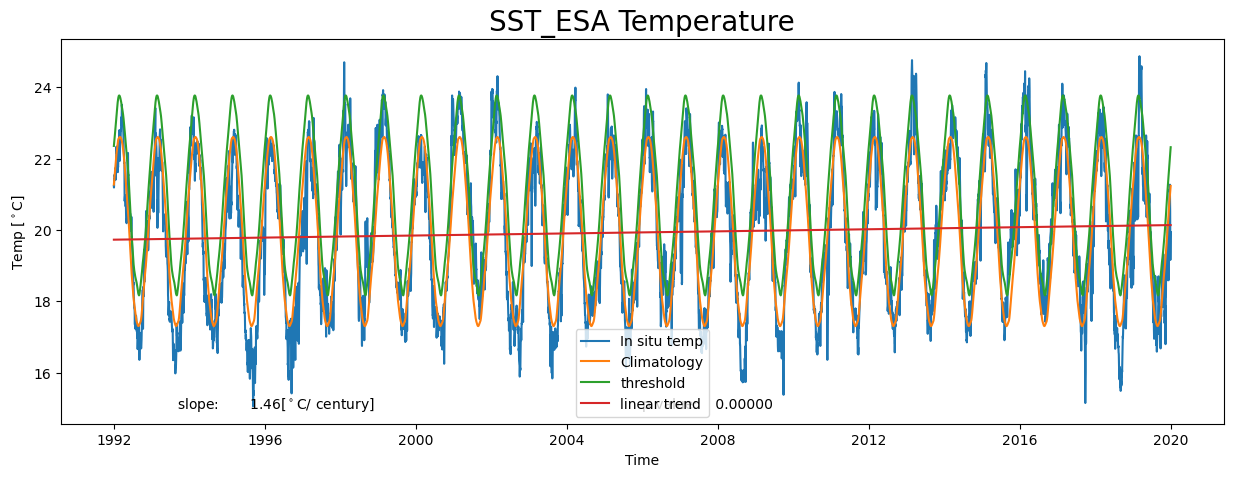

In [8]:
### Plot
plt.figure(1,figsize=(15,5))
ax=plt.subplot(1,1,1)
plt.plot(times_dates,sst)
plt.xlabel('Time')
plt.ylabel('Temp [$^\circ$C]')
plt.title(Name_platform + ' Temperature', size=20)
plt.plot(times_dates,clim['seas'])
plt.plot(times_dates,clim['thresh'])    

from scipy import stats
# Trend: linear regression
nogaps = (~np.isnan(t) & ~np.isnan(sst))    
slope, intercept, r_value, p_value, std_err = stats.linregress(t[nogaps],sst[nogaps]) 
yhat = intercept + slope*t    
print(slope)
print(p_value)
plt.plot(times_dates,yhat)
plt.legend(['In situ temp','Climatology','threshold','linear trend'])
plt.text(0.1, 0.05,'slope: ' + "{:10.2f}".format(slope*365*100) + '[$^\circ$C/ century]', ha='left', va='center', transform=ax.transAxes)
plt.text(0.5, 0.05,'p value: ' + "{:10.5f}".format(p_value), ha='left', va='center', transform=ax.transAxes)

plt.savefig(plot_folder + 'Plot_sst_clim.png')
plt.show()


# Statistics MHWs

In [9]:
## Stats
if mhws['n_events'] == 0:
    print('NO MARINE HEATWAVE!!!!')
else:
    ev = np.argmax(mhws['intensity_max']) # Find largest event in terms of intensity
    print('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
    print('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
    print('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
    print('Duration:', mhws['duration'][ev], 'days')
    print('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
    print('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))


Maximum intensity: 3.027279251714951 deg. C
Average intensity: 2.1146905986193367 deg. C
Cumulative intensity: 67.67009915581878 deg. C-days
Duration: 32 days
Start date: 08 December 2000
End date: 08 January 2001


# Time-series of MHWs

In [10]:
sst_ano_thresh = sst - clim['thresh']
sst_ano = sst - clim['seas']

# More time-series
sst_ano_pos = sst * 0     # only for positive anomalies
list_MHWstats_1_0 = sst * 0 
# Fill values only when MHW 
for i in range(mhws['n_events']):    # loop events
    ind_MHW = np.array(range(mhws['index_start'][i], mhws['index_end'][i]+1)) 
    list_MHWstats_1_0[ind_MHW] = 1
    sst_ano_pos[ind_MHW] = sst_ano[ind_MHW]     # only for positive anomalies


In [11]:
## Add in list
####################
clim['sst'] = sst             
clim['times_dates'] = times_dates              
clim['t'] = t            
clim['list_MHWstats_1_0'] = list_MHWstats_1_0          
clim['sst_ano_thresh'] = sst_ano_thresh          
clim['sst_ano'] = sst_ano            
####################


# Stats trends, seasonality

In [12]:
# Create dataframe and recalculate summer and winter with it
import pandas as pd 

df_SST_all_daily=pd.DataFrame(clim['list_MHWstats_1_0'],pd.DatetimeIndex(times_dates, name='t'))
df_SST_all_daily.columns = ['MHWdays']

### Seasons
winter_3m = ((df_SST_all_daily.index.month >6) & (df_SST_all_daily.index.month <10)) # Jun - Aug
summer_3m = ((df_SST_all_daily.index.month <4)) # Jan - Mar 


df_SST_all_yearly_MHWdays_year = df_SST_all_daily.groupby(df_SST_all_daily.index.year).sum()
# 3 months
df_SST_all_yearly_MHWdays_winter_3m = df_SST_all_daily[winter_3m].groupby(df_SST_all_daily[winter_3m].index.year).sum()
df_SST_all_yearly_MHWdays_summer_3m = df_SST_all_daily[summer_3m].groupby(df_SST_all_daily[summer_3m].index.year).sum()


# Save

In [14]:
## Save the data in file
import shelve
d = shelve.open('DATA_processed/SSAVE_' + Name_platform + '_mhws_Strength2018_sst2019') 
d['dict_clim'] = clim            
d['df_SST_all_yearly_MHWdays_year'] = df_SST_all_yearly_MHWdays_year            
d['df_SST_all_yearly_MHWdays_summer_3m'] = df_SST_all_yearly_MHWdays_summer_3m            
d['df_SST_all_yearly_MHWdays_winter_3m'] = df_SST_all_yearly_MHWdays_winter_3m            
d.close()       
